In [89]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import random
import uuid
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [58]:
df = pd.read_csv("../data/raw/bank_transactions.csv")
df.head()

,transaction_id,customer_id,transaction_time,transaction_amount,transaction_type,merchant_category,transaction_location,is_declined,is_fraud
0,b4de2ec0,CUST_0041,2024-01-01 00:02:00,2097.23,ATM,NaN,Kano,0,0
1,458c242d,CUST_0077,2024-01-01 00:50:00,2088.17,Transfer,NaN,Abuja,0,0
2,b56ef188,CUST_0005,2024-01-01 00:55:00,1427.17,ATM,NaN,Abuja,0,0
3,ecfdcdae,CUST_0054,2024-01-01 00:56:00,2539.90,ATM,NaN,Ibadan,0,0
4,47fcf1f1,CUST_0007,2024-01-01 01:00:00,25.71,Transfer,NaN,Port Harcourt,0,0


In [59]:
# Original columns
df.columns

Index(['transaction_id', 'customer_id', 'transaction_time',
       'transaction_amount', 'transaction_type', 'merchant_category',
       'transaction_location', 'is_declined', 'is_fraud'],
      dtype='object')

In [101]:
features_inf = df.drop(columns=["is_fraud"]).columns.tolist()

In [104]:
features_types = df.drop(columns=["is_fraud"]).dtypes.to_dict()
features_types

{'transaction_id': dtype('O'),
 'customer_id': dtype('O'),
 'transaction_time': dtype('O'),
 'transaction_amount': dtype('float64'),
 'transaction_type': dtype('O'),
 'merchant_category': dtype('O'),
 'transaction_location': dtype('O'),
 'is_declined': dtype('int64')}

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4569 entries, 0 to 4568
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   transaction_id        4569 non-null   object 
 1   customer_id           4569 non-null   object 
 2   transaction_time      4569 non-null   object 
 3   transaction_amount    4569 non-null   float64
 4   transaction_type      4569 non-null   object 
 5   merchant_category     2261 non-null   object 
 6   transaction_location  4569 non-null   object 
 7   is_declined           4569 non-null   int64  
 8   is_fraud              4569 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 321.4+ KB


Merchant category has missing values.

In [61]:
print("\nShape:", df.shape)
print("Fraud rate:", round(df["is_fraud"].mean() * 100, 2), "%")


Shape: (4569, 9)
Fraud rate: 4.16 %


In [62]:
df.dtypes

transaction_id           object
customer_id              object
transaction_time         object
transaction_amount      float64
transaction_type         object
merchant_category        object
transaction_location     object
is_declined               int64
is_fraud                  int64
dtype: object

In [63]:
df.describe().T # summary statistics for the numerical columns

,count,mean,std,min,25%,50%,75%,max
transaction_amount,4569.0,1502.829037,874.431133,10.16,748.28,1501.91,2277.63,2999.23
is_declined,4569.0,0.053185,0.224426,0.00,0.00,0.00,0.00,1.00
is_fraud,4569.0,0.041585,0.199660,0.00,0.00,0.00,0.00,1.00


In [64]:
df.describe(include="object")  # summary statistics for the categorical columns

,transaction_id,customer_id,transaction_time,transaction_type,merchant_category,transaction_location
count,4569,4569,4569,4569,2261,4569
unique,4569,100,4469,4,5,5
top,be95cee7,CUST_0037,2024-01-16 16:18:00,ATM,Groceries,Ibadan
freq,1,76,2,1177,472,954


array([[<Axes: title={'center': 'transaction_amount'}>]], dtype=object)

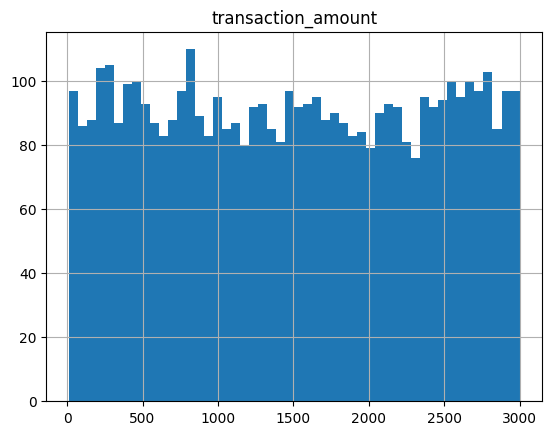

In [15]:
df.hist(column="transaction_amount", bins=50)

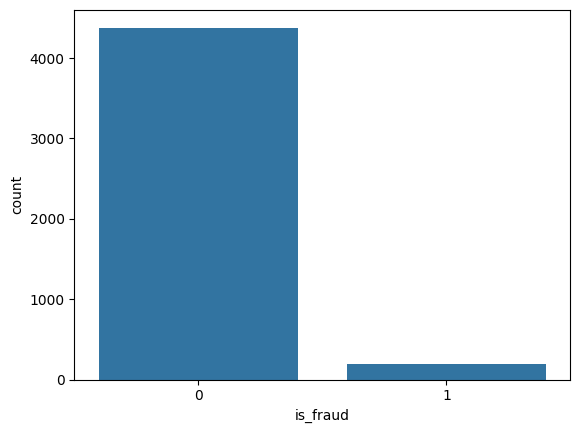

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x="is_fraud", data=df)
plt.show()

In [66]:
# load the dataset with the engineered features - from src/featurer.py
df_feat = pd.read_csv("../data/interim/engineered_bank_transactions.csv")

In [20]:
df_feat.head()

,transaction_id,customer_id,transaction_time,transaction_amount,transaction_type,merchant_category,transaction_location,is_declined,is_fraud,transaction_hour,transaction_day_of_week,customer_num_txn_1d,customer_num_txn_7d,customer_avg_amount_7d,time_since_last_txn,num_unique_locations_1h,customer_account_age_days
0,c914b423,CUST_0001,2024-01-01 12:49:00,519.87,POS,Groceries,Port Harcourt,0,0,12,0,0,0,0.000000,0.0,0,0
1,0bddd0e3,CUST_0001,2024-01-01 14:20:00,2897.24,Online,Electronics,Abuja,0,0,14,0,1,1,519.870000,91.0,0,0
2,5d687e2d,CUST_0001,2024-01-02 21:47:00,302.04,POS,Restaurants,Lagos,0,0,21,1,0,2,1708.555000,1887.0,0,1
3,1566cdde,CUST_0001,2024-01-03 16:50:00,374.89,ATM,NaN,Lagos,0,0,16,2,1,3,1239.716667,1143.0,0,2
4,b593edf7,CUST_0001,2024-01-04 16:31:00,2728.87,POS,Groceries,Abuja,0,0,16,3,1,4,1023.510000,1421.0,0,3


In [67]:
df_feat.columns # check new columns after feature engineering 

Index(['transaction_id', 'customer_id', 'transaction_time',
       'transaction_amount', 'transaction_type', 'merchant_category',
       'transaction_location', 'is_declined', 'is_fraud', 'transaction_hour',
       'transaction_day_of_week', 'customer_num_txn_1d', 'customer_num_txn_7d',
       'customer_avg_amount_7d', 'time_since_last_txn',
       'num_unique_locations_1h', 'customer_account_age_days'],
      dtype='object')

In [68]:
df_feat.dtypes

transaction_id                object
customer_id                   object
transaction_time              object
transaction_amount           float64
transaction_type              object
merchant_category             object
transaction_location          object
is_declined                    int64
is_fraud                       int64
transaction_hour               int64
transaction_day_of_week        int64
customer_num_txn_1d            int64
customer_num_txn_7d            int64
customer_avg_amount_7d       float64
time_since_last_txn          float64
num_unique_locations_1h        int64
customer_account_age_days      int64
dtype: object

In [30]:
dft = df_feat.copy # create a copy to work on

In [69]:
df_feat.head()

,transaction_id,customer_id,transaction_time,transaction_amount,transaction_type,merchant_category,transaction_location,is_declined,is_fraud,transaction_hour,transaction_day_of_week,customer_num_txn_1d,customer_num_txn_7d,customer_avg_amount_7d,time_since_last_txn,num_unique_locations_1h,customer_account_age_days
0,c914b423,CUST_0001,2024-01-01 12:49:00,519.87,POS,Groceries,Port Harcourt,0,0,12,0,0,0,0.000000,0.0,0,0
1,0bddd0e3,CUST_0001,2024-01-01 14:20:00,2897.24,Online,Electronics,Abuja,0,0,14,0,1,1,519.870000,91.0,0,0
2,5d687e2d,CUST_0001,2024-01-02 21:47:00,302.04,POS,Restaurants,Lagos,0,0,21,1,0,2,1708.555000,1887.0,0,1
3,1566cdde,CUST_0001,2024-01-03 16:50:00,374.89,ATM,NaN,Lagos,0,0,16,2,1,3,1239.716667,1143.0,0,2
4,b593edf7,CUST_0001,2024-01-04 16:31:00,2728.87,POS,Groceries,Abuja,0,0,16,3,1,4,1023.510000,1421.0,0,3


In [70]:
# data preprocessing
# === Handle Missing Values for Merchant Category ===
df_feat["merchant_category"] = df_feat["merchant_category"].fillna("Unknown")
    
    # === Sort by time ===
df_feat = df_feat.sort_values("transaction_time").reset_index(drop=True)

In [72]:
 # === Features & Target ===
drop_cols = ["is_fraud", "transaction_id", "transaction_time", "customer_id"]
features = [c for c in df_feat.columns if c not in drop_cols]
features

['transaction_amount',
 'transaction_type',
 'merchant_category',
 'transaction_location',
 'is_declined',
 'transaction_hour',
 'transaction_day_of_week',
 'customer_num_txn_1d',
 'customer_num_txn_7d',
 'customer_avg_amount_7d',
 'time_since_last_txn',
 'num_unique_locations_1h',
 'customer_account_age_days']

In [73]:
# === Identify feature types ===
categorical_features = ["transaction_type", "merchant_category", "transaction_location"]
numeric_features = [c for c in features if c not in categorical_features]
    
    # === Numeric Preprocessing: Fill missing with median + scale ===
numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    
    # === Categorical Preprocessing: Encode ===
categorical_transformer = Pipeline(steps=[
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
    ])
    
    # === Combine Preprocessing ===
preprocessor = ColumnTransformer([
        ("categorical", categorical_transformer, categorical_features),
        ("numeric", numeric_transformer, numeric_features)
])

In [74]:
# Split data into train and test sets- usng the dataet dft
# Splinting based on time to prevent data leakage

df_feat = df_feat.sort_values("transaction_time").reset_index(drop=True)
total = len(df_feat)
train_end = int(0.7 * total)
val_end = int(0.85 * total)
    
train_df = df_feat.iloc[:train_end]
val_df = df_feat.iloc[train_end:val_end]
test_df = df_feat.iloc[val_end:]


X_train, y_train = train_df[features], train_df["is_fraud"]
X_val, y_val = val_df[features], val_df["is_fraud"]
X_test, y_test = test_df[features], test_df["is_fraud"]

In [84]:
df_feat.columns

Index(['transaction_id', 'customer_id', 'transaction_time',
       'transaction_amount', 'transaction_type', 'merchant_category',
       'transaction_location', 'is_declined', 'is_fraud', 'transaction_hour',
       'transaction_day_of_week', 'customer_num_txn_1d', 'customer_num_txn_7d',
       'customer_avg_amount_7d', 'time_since_last_txn',
       'num_unique_locations_1h', 'customer_account_age_days'],
      dtype='object')

In [75]:
from collections import Counter

# Count classes in training set
counter = Counter(y_train)
neg = counter[0]   # majority
pos = counter[1]   # minority

print("Negative:", neg, "Positive:", pos)

# XGBoost weight
scale_pos_weight = neg / pos
print("XGBoost scale_pos_weight =", scale_pos_weight)

# CatBoost weights (balanced formula)
total = neg + pos
catboost_class_weights = [
    total / (2 * neg),   # weight for class 0
    total / (2 * pos)    # weight for class 1
]

print("CatBoost class_weights =", catboost_class_weights)


Negative: 3065 Positive: 133
XGBoost scale_pos_weight = 23.045112781954888
CatBoost class_weights = [0.5216965742251224, 12.022556390977444]


## Model Training Pipeline

In [76]:
# === Models to Train ===
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression



models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=10, class_weight="balanced", random_state=42),
        "XGBoost": xgb.XGBClassifier(
            n_estimators=200,
            max_depth=6,
            learning_rate=0.05,
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        ),
        "LightGBM": lgb.LGBMClassifier(
            n_estimators=200,
            num_leaves=31,
            class_weight="balanced",
            random_state=42
        ),
        "CatBoost": CatBoostClassifier(
            iterations=200,
            depth=6,
            learning_rate=0.05,
            verbose=0,
            random_state=42,
            class_weights=catboost_class_weights
        )
    }

In [81]:
# ==========================================
# 4. TRAIN + EVALUATE + THRESHOLD TUNING
# ==========================================
pipelines = {}
results = []

for name, model in models.items():
    print(f"\nTraining: {name}")
    
    pipe = Pipeline([
        ("preprocess", preprocessor),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    print(f" {name} has been fitted")
    pipelines[name] = pipe


Training: Logistic Regression
 Logistic Regression has been fitted

Training: Random Forest
 Random Forest has been fitted

Training: XGBoost
 XGBoost has been fitted

Training: LightGBM
[LightGBM] [Info] Number of positive: 133, number of negative: 3065
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 904
[LightGBM] [Info] Number of data points in the train set: 3198, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
 LightGBM has been fitted

Training: CatBoost
 CatBoost has been fitted


In [82]:
# ----- Validation threshold tuning -----
from sklearn.metrics import precision_recall_curve

val_proba = pipe.predict_proba(X_val)[:,1]
precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)
f1 = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
print(f" Best validation threshold: {best_threshold:.3f}")
    
    # ----- Test Set Metrics -----
test_proba = pipe.predict_proba(X_test)[:,1]
test_pred = (test_proba >= best_threshold).astype(int)
    
report = classification_report(y_test, test_pred, output_dict=True)
roc = roc_auc_score(y_test, test_proba)
    
results.append({
        "Model": name,
        "Best_Threshold": best_threshold,
        "Precision": report["1"]["precision"],
        "Recall": report["1"]["recall"],
        "F1": report["1"]["f1-score"],
        "ROC-AUC": roc
    })

 Best validation threshold: 0.398


In [83]:
# ==========================================
# 5. SELECT BEST MODEL
# ==========================================
results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\n=== MODEL PERFORMANCE ===")
print(results_df)

best_model_name = results_df.iloc[0]["Model"]
best_threshold = results_df.iloc[0]["Best_Threshold"]
print(f"\n Best Model: {best_model_name}")
print(f" Best Threshold: {best_threshold:.3f}")


=== MODEL PERFORMANCE ===
      Model  Best_Threshold  Precision    Recall        F1   ROC-AUC
0  CatBoost        0.397611   0.090909  0.173913  0.119403  0.585088

 Best Model: CatBoost
 Best Threshold: 0.398


In [105]:
# ==========================================
# 6. SAVE FINAL MODEL + THRESHOLD
# ==========================================
import joblib

joblib.dump({
    "model": pipelines[best_model_name],
    "threshold": best_threshold,
    "features": features_types,
}, "../models/best_fraud_model.pkl")

print("\n Model saved to model/best_fraud_model.pkl")


 Model saved to model/best_fraud_model.pkl


In [90]:
sys.path.append(os.path.abspath("../"))
sys.path.append(os.path.abspath("../src"))
from src.features import engineer_features

In [107]:
# Using the model for inference
from src.features import engineer_features

import joblib
import pandas as pd

saved = joblib.load("../models/best_fraud_model.pkl")
model = saved["model"]
threshold = saved["threshold"]
features = saved["features"]

# example input
new_data = pd.DataFrame([{
    "transaction_id": "fd5e5a75",
    "customer_id": "CUST_0007",
    "transaction_time": "2024-01-02 01:24:00",
    "transaction_amount": 2424.22,
    "transaction_type": "Online",
    "merchant_category": "Groceries",
    "transaction_location": "Abuja",
    "is_declined": 1
}])
# feature engineering
new_data = engineer_features(new_data)

#new_data["transaction_time"] = pd.to_datetime(new_data["transaction_time"])

proba = model.predict_proba(new_data)[0][1]
prediction = int(proba >= threshold)

print("Fraud Probability:", proba)
print("Prediction:", prediction)


Fraud Probability: 0.3233133099046895
Prediction: 0


In [108]:
features_types

{'transaction_id': dtype('O'),
 'customer_id': dtype('O'),
 'transaction_time': dtype('O'),
 'transaction_amount': dtype('float64'),
 'transaction_type': dtype('O'),
 'merchant_category': dtype('O'),
 'transaction_location': dtype('O'),
 'is_declined': dtype('int64')}